In [1]:
from google.colab import files

fl = files.upload()



Saving irf1000_startindex0.npy to irf1000_startindex0.npy


In [2]:
import numpy as np

irf = np.load("irf1000_startindex0.npy")

print(irf)

print(np.argmax(irf))

# irf = irf[np.argmax(irf):]


[1.00000000e+00 0.00000000e+00 3.95995996e+00 2.06006006e+00
 2.08008008e+00 3.20020020e+00 2.48048048e+00 3.14014014e+00
 4.51951952e+00 2.81981982e+00 3.40040040e+00 1.44044044e+00
 4.48048048e+00 3.47947948e+00 3.15915916e+00 1.30030030e+00
 1.64064064e+00 1.65965966e+00 4.44144144e+00 3.61961962e+00
 2.80080080e+00 4.15915916e+00 3.67867868e+00 2.38138138e+00
 1.51951952e+00 1.00100100e+00 2.52052052e+00 4.16216216e+00
 4.68168168e+00 3.90290290e+00 1.60060060e+00 2.62062062e+00
 2.64064064e+00 2.33933934e+00 3.00000000e+00 6.40140140e+00
 3.55855856e+00 5.18518519e-01 2.52152152e+00 3.56156156e+00
 3.00000000e+00 3.35835836e+00 6.04504505e+00 1.00000000e+00
 3.00000000e+00 3.60360360e+00 2.92092092e+00 1.00000000e+00
 6.80480480e+00 5.94294294e+00 1.00400400e+00 1.10510511e+00
 9.58958959e-01 4.87787788e+00 2.91891892e+00 2.20220220e+00
 3.75775776e+00 5.43543544e+00 2.00000000e+00 2.00000000e+00
 3.59759760e+00 1.22122122e+00 1.24124124e+00 1.47747748e+00
 6.59359359e+00 2.205205

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

density = 1000

# Modified 29 March
def generate_gaussian():
    x = np.array(range(density))
    y = irf

    return (x,y)


# def generate_gaussian():
#     mu = np.random.uniform(low=5,high=30)
#     variance = 20
#     sigma = math.sqrt(variance)
#     x = np.linspace(mu - 3*sigma, mu + 3*sigma, 25)
#     y = stats.norm.pdf(x, mu, sigma) * np.random.uniform(low=1, high=8)


#     pref_x = np.array(range(density))
#     new_y = np.interp(pref_x,x,y)

#     new_y += np.random.uniform(low=0,high=0.1,size=(density,))

#     return (pref_x,new_y)



def f(x,a,tau):
    return a * np.exp(-x/tau)


def generate_decay_curve(amin,amax,taumin,taumax):
    a = np.random.uniform(low=amin,high=amax)
    tau = np.random.uniform(low=taumin,high=taumax)
    x = np.array(range(density))
    y = f(x,a,tau)

    return (y,a,tau)
    

def generate_dataset():
    (x,y) = generate_gaussian()
    (dec_y,a,t) = generate_decay_curve()
    z = np.convolve(y,dec_y)[:density]
    # z += np.random.uniform(0,0.2)
    z = z +  np.random.uniform(low=-z/6,high=z/6, size=density)


    input = np.concatenate((z,y))

    t = t/50
    output = (a,t)

    return (input,output)

In [4]:
def generate_dataset_three():
    (x,y) = generate_gaussian()
    
    (dec_y,a,t) = generate_decay_curve(amin=0.1,amax=1,taumin=0.1,taumax=5)
    (dec_y_2,a2,t2) = generate_decay_curve(amin=0.1,amax=1,taumin=5,taumax=15)
    (dec_y_3,a3,t3) = generate_decay_curve(amin=0.1,amax=1,taumin=15,taumax=100)

    new_dec = dec_y + dec_y_2 + dec_y_3

    t = t/5
    t2 = (t2 - 5)/10
    t3 = (t3-15)/85

    z = np.convolve(y,new_dec)[:density]
    z = z +  np.random.uniform(low=-z/6,high=z/6, size=density)

    input = np.concatenate((z,y))
    output = np.array([a,t,a2,t2,a3,t3])
    output = output.reshape(6)

    return (input,output)

In [5]:
""
x_list = []
y_list = []
for i in range(100000):
  
    (x,y) = generate_dataset_three()
  
    x_list.append(x)
    y_list.append(y)

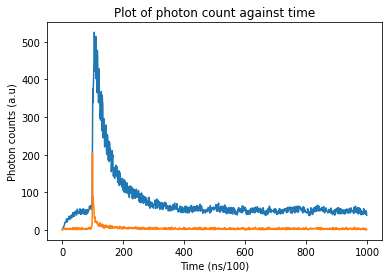

In [6]:
import matplotlib.pyplot as plt


x = np.array(range(density))
plt.plot(x,x_list[0][:density])
plt.plot(x,x_list[0][density:])
plt.xlabel("Time (ns/100)")
plt.ylabel("Photon counts (a.u)")
plt.title("Plot of photon count against time")
a = y_list[0][0]
tau = y_list[0][1]

# plt.plot(x,f(x,a,tau))
plt.show()

In [7]:
import tensorflow as tf

x_list = np.array(x_list)
y_list = np.array(y_list)

x_list = tf.keras.utils.normalize(x_list)

print(x_list.shape)
print(y_list.shape)



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_list, y_list, test_size=0.10, random_state=40)




(100000, 2000)
(100000, 6)


In [8]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
import tensorflow as tf


model = Sequential()
model.add(Dense(200, activation='relu', input_dim=density*2))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(6, activation='relu'))

In [9]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=50, validation_split=0.2)
# model.summary()

Epoch 1/50
563/563 [==============================] - 11s 19ms/step - loss: 0.1733 - accuracy: 0.1692 - val_loss: 0.0752 - val_accuracy: 0.2130
Epoch 2/50
563/563 [==============================] - 10s 18ms/step - loss: 0.0916 - accuracy: 0.1753 - val_loss: 0.0699 - val_accuracy: 0.2149
Epoch 3/50
563/563 [==============================] - 10s 17ms/step - loss: 0.0815 - accuracy: 0.2126 - val_loss: 0.0617 - val_accuracy: 0.2706
Epoch 4/50
563/563 [==============================] - 10s 17ms/step - loss: 0.0747 - accuracy: 0.2476 - val_loss: 0.0578 - val_accuracy: 0.2917
Epoch 5/50
563/563 [==============================] - 10s 18ms/step - loss: 0.0695 - accuracy: 0.2726 - val_loss: 0.0544 - val_accuracy: 0.3087
Epoch 6/50
563/563 [==============================] - 10s 18ms/step - loss: 0.0661 - accuracy: 0.2898 - val_loss: 0.0519 - val_accuracy: 0.3234
Epoch 7/50
563/563 [==============================] - 10s 18ms/step - loss: 0.0634 - accuracy: 0.3018 - val_loss: 0.0502 - val_accuracy:

In [10]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0336 - accuracy: 0.4900


[0.0336458757519722, 0.49000000953674316]

In [11]:
m_list = []
n_list = []
for i in range(50):
  (m,n) = generate_dataset_three()
  m_list.append(m)
  n_list.append(n)


m = np.array(m_list)
m = tf.keras.utils.normalize(m)
n = np.array(n_list)

# print(n_list)

In [12]:

pred_n = model.predict(m)

In [ ]:
pred_n = np.array(pred_n)

Text(0.5, 1.0, 'A plot of 50 points of predicted intensity against generated\n intensity for a triple exponential decay model with fixed IRF')

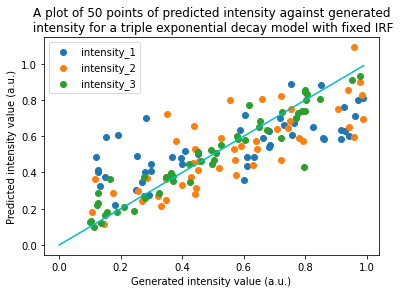

In [ ]:
n_list_ = np.array(n_list).T
pred_n_ = pred_n.T

# n_list_0 = n_list_[1] * 5
# pred_n_0 = pred_n_[1] * 5

# n_list_1 = n_list_[3] * 10 + 5
# pred_n_1 = pred_n_[3] * 10 + 5

# # n_list_2 = n_list_[5] * 85 + 15
# # pred_n_2 = pred_n_[5] * 85 + 15


n_list_0 = n_list_[0]
pred_n_0 = pred_n_[0]

n_list_1 = n_list_[2]
pred_n_1 = pred_n_[2]

n_list_2 = n_list_[4]
pred_n_2 = pred_n_[4]


x = np.array(range(100))/100




plt.plot(x,x,c='c')
plt.scatter(n_list_0,pred_n_0,label="intensity_1")
plt.scatter(n_list_1,pred_n_1,label="intensity_2")
plt.scatter(n_list_2,pred_n_2,label="intensity_3")

plt.legend()
plt.xlabel("Generated intensity value (a.u.)")
plt.ylabel("Predicted intensity value (a.u.)")
plt.title("A plot of 50 points of predicted intensity against generated\n intensity for a triple exponential decay model with fixed IRF")
# # plt.show()



[[0.6286652  0.6162846  0.7908453  0.5742768  0.48382023 0.87156963]]
[0.93586654 0.48480475 0.66629076 0.63740557 0.4695396  0.91487655]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


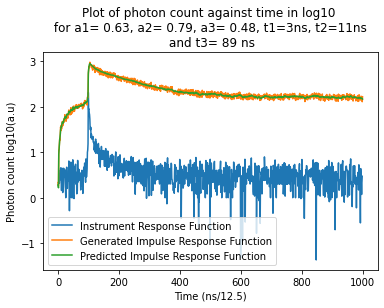

In [17]:
(m,n) = generate_dataset_three()

m_norm = tf.keras.utils.normalize(m)

m_norm = np.array(m_norm)

pred_n = model.predict(m_norm)

print(pred_n)

x = np.array(range(density))
a = float(pred_n[0][0])
tau = float(pred_n[0][1])*5
a2 = float(pred_n[0][2])
tau2 = float(pred_n[0][3]) * 10 + 5
a3 = float(pred_n[0][4])
tau3 = float(pred_n[0][5]) * 85 + 15
irf = m[density:]
y = (np.convolve(irf, f(x,a,tau) + f(x,a2,tau2) + f(x,a3,tau3)))[:density]
     

plt.plot(x,np.log10(irf),label="Instrument Response Function")
plt.plot(x,np.log10(m[:density]),label="Generated Impulse Response Function")
plt.plot(x,np.log10(y),label="Predicted Impulse Response Function")
plt.legend()
plt.xlabel("Time (ns/12.5)")
plt.ylabel("Photon count log10(a.u)")
plt.title("Plot of photon count against time in log10 \n for a1= {}, a2= {}, a3= {}, t1={}ns, t2={}ns \n and t3= {} ns".format(round(a,2),round(a2,2),round(a3,2), round(tau),round(tau2),round(tau3)))
print(n)

plt.show()

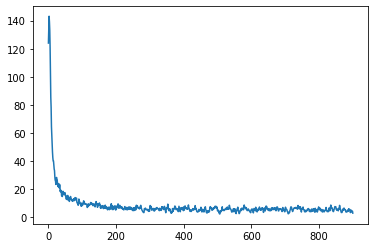

In [ ]:



y = np.convolve(irf,f(x,a,tau))[:density]

# print(y)

plt.plot(x,y)
plt.show()

In [ ]:
# n_ = 1 - (pred_n-n)/ n


# print(np.mean(n_, axis=0))

n = np.array(n_list)
pred_n_ = pred_n



# print(np.mean(n,axis=0))
# print(np.mean(pred_n_,axis=0))


y = 1 - np.average(np.absolute((pred_n_-n)/pred_n_),axis=0)
print(y)



[0.69536026 0.53526348 0.7315902  0.52982664 0.86618213 0.89489905]


In [ ]:
model.save("mymodel")

INFO:tensorflow:Assets written to: mymodel/assets


In [ ]:
fl = files.upload()

Saving NACL_90_1000.npy to NACL_90_1000.npy


In [ ]:
obs = np.load("NACL_90_1000.npy")[:density]

In [ ]:

obsdecay = np.concatenate((obs,irf))
cc_norm = tf.keras.utils.normalize(obsdecay)
y = model.predict(np.array(cc_norm))

print(y)

[[0.47364455 0.22900233 0.05357273 0.3585965  0.85093623 0.10395478]]


0.47364455461502075 0.05357272922992706 0.850936233997345
1.1450116336345673 8.585965037345886 83.34601551294327


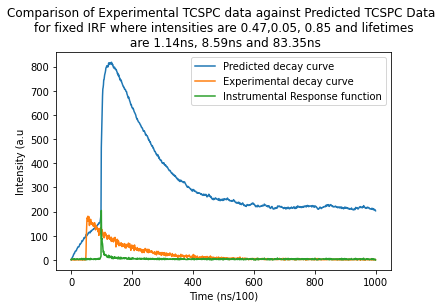

In [ ]:
a = float(y[0][0])
tau = float(y[0][1])*5
a2 = float(y[0][2])
tau2 = float(y[0][3]) * 10 + 5
a3 = float(y[0][4])
tau3 = float(pred_n[0][5]) * 85 + 15

print(a,a2,a3)
print(tau,tau2,tau3)

x = np.array(range(density))

obs = np.convolve(f(x,y[0][0],tau) + f(x,y[0][2],tau2) + f(x,y[0][4],tau3),irf)[:density]


plt.plot(x,obs, label="Predicted decay curve")
plt.plot(x, obsdecay[:density],label="Experimental decay curve")
plt.plot(x,irf,label="Instrumental Response function")
plt.title("Comparison of Experimental TCSPC data against Predicted TCSPC Data \nfor fixed IRF where intensities are 0.47,0.05, 0.85 and lifetimes\n are 1.14ns, 8.59ns and 83.35ns")
plt.ylabel("Intensity (a.u")
plt.xlabel("Time (ns/100)")
plt.legend()
plt.plot()
plt.show()